In [2]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense

# Step 2: Load the dataset
file_path = './weather_data.csv'
data = pd.read_csv(file_path, parse_dates=['date'])
print(data.head())

        date  temperature
0 2014-01-01    10.248357
1 2014-01-02     9.950428
2 2014-01-03    10.362958
3 2014-01-04    10.820167
4 2014-01-05     9.961091


In [3]:
# Step 3: Preprocess the data
# Normalize the temperature column
scaler = MinMaxScaler()
data['temperature_normalized'] = scaler.fit_transform(data[['temperature']])

# Prepare the input data for the LSTM (sequence data)
time_steps = 30  # Number of days in each sequence
sequences = []
for i in range(len(data) - time_steps):
    seq = data['temperature_normalized'].iloc[i : i + time_steps].values
    sequences.append(seq)
sequences = np.array(sequences)

# Split data into training and testing sets
X_train, X_test = train_test_split(sequences, test_size=0.2, random_state=42)

# Reshape for LSTM input (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [4]:
# Step 4: Build the LSTM Autoencoder
# Define the model
input_dim = X_train.shape[1]
latent_dim = 16  # Dimension of the latent representation

# Encoder
inputs = Input(shape=(time_steps, 1))
encoded = LSTM(latent_dim, activation='relu')(inputs)

# Decoder
decoded = RepeatVector(time_steps)(encoded)
decoded = LSTM(10, activation='relu', return_sequences=True)(decoded)
outputs = TimeDistributed(Dense(1))(decoded)

# Autoencoder Model
autoencoder = Model(inputs, outputs)
autoencoder.compile(optimizer='adam', loss='mse')

# Display the model summary
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 30, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 16)                  │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 30, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 30, 10)              │           1,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 30, 1)               │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,243 (8.76 KB)

 Trainable params: 2,243 (8.76 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Step 5: Train the model
history = autoencoder.fit(
    X_train, X_train,
    epochs=5,
    batch_size=32,
    validation_split=0.2,
    shuffle=True
)


Epoch 1/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 2/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 3/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 4/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 5/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0023 - val_loss: 0.0024


In [8]:
# Step 6: Evaluate reconstruction error on test set
X_test_pred = autoencoder.predict(X_test)
reconstruction_error = np.mean(np.abs(X_test_pred - X_test), axis=(1, 2))

# Define a threshold for anomaly detection

threshold = np.percentile(reconstruction_error, 95)
print(f"Reconstruction error threshold: {threshold}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Reconstruction error threshold: 0.04913332575864655


In [9]:
# Step 7: Anomaly detection on the entire dataset
data_sequences = []
for i in range(len(data) - time_steps):
    seq = data['temperature_normalized'].iloc[i : i + time_steps].values
    data_sequences.append(seq)
data_sequences = np.array(data_sequences).reshape((-1, time_steps, 1))

data_pred = autoencoder.predict(data_sequences)
data_reconstruction_error = np.mean(np.abs(data_pred - data_sequences), axis=(1, 2))

# Mark anomalies in the data
anomalies = data.iloc[time_steps:][data_reconstruction_error > threshold]


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


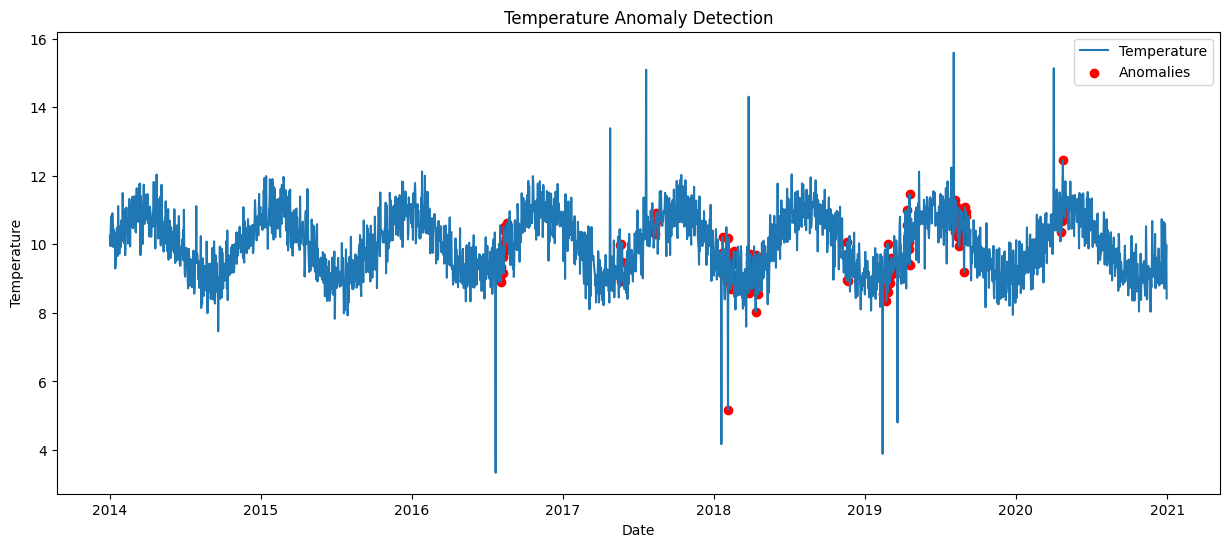

In [10]:
# Step 8: Visualize the results
plt.figure(figsize=(15, 6))
plt.plot(data['date'], data['temperature'], label="Temperature")
plt.scatter(anomalies['date'], anomalies['temperature'], color='red', label="Anomalies")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.legend()
plt.title("Temperature Anomaly Detection")
plt.show()

# Interpretaion

The LSTM Autoencoder was trained to learn normal temperature patterns by minimizing reconstruction error. Days with significantly higher reconstruction errors (above the 95th percentile threshold) were flagged as anomalies, indicating unusual temperature behavior or potential data issues. The visualization highlights these anomalies as red points on the temperature plot, providing a clear distinction between normal and anomalous days for further analysis.